In [211]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#############train 컬럼 설명#######################
#ID : 샘플별 고유 ID
# gender : 성별
# age : 연령
# height : 키(cm)
# weight : 몸무게(kg)
# cholesterol : 콜레스테롤 수치
# systolic_blood_pressure : 수축기 혈압
# diastolic_blood_pressure : 이완기 혈압
# glucose : 혈당 수치(mg/dL)
# bone_density : 골밀도(g/cm²)
# activity : 생활시 운동 강도
# smoke_status : 흡연 상태
# medical_history : 만성질환
# family_medical_history : 가족력
# sleep_pattern : 수면패턴
# edu_level : 학력
# mean_working : 1주일당 평균 근로 시간
# stress_score : (TARGET) 스트레스 점수 


###############test 컬럼 설명######################
# ID : 샘플별 고유 ID
# gender : 성별
# age : 연령
# height : 키(cm)
# weight : 몸무게(kg)
# cholesterol : 콜레스테롤 수치
# systolic_blood_pressure : 수축기 혈압
# diastolic_blood_pressure : 이완기 혈압
# glucose : 혈당 수치(mg/dL)
# bone_density : 골밀도(g/cm²)
# activity : 생활시 운동 강도
# smoke_status : 흡연 상태
# medical_history : 만성질환
# family_medical_history : 가족력
# sleep_pattern : 수면패턴
# edu_level : 학력
# mean_working : 1주일당 평균 근로 시간


#########sample_submission.csv [파일] - 제출양식#######
# ID : 샘플별 고유 ID
# stress_score : (TARGET) 스트레스 점수


In [212]:
#train_data
train = pd.read_csv('D:\\workspace_1\\dacon_venv\\test\\dataset\\train.csv')

#test data
test = pd.read_csv('D:\\workspace_1\\dacon_venv\\test\\dataset\\test.csv')

In [213]:
#학습 데이터는 총 19개의 변수 3000개의 데이터를 가지고 있다. 

train.count

<bound method DataFrame.count of               ID gender  age  height  weight  cholesterol  \
0     TRAIN_0000      F   72  161.49   58.47       279.84   
1     TRAIN_0001      M   88  179.87   77.60       257.37   
2     TRAIN_0002      M   47  182.47   89.93       226.66   
3     TRAIN_0003      M   69  185.78   68.63       206.74   
4     TRAIN_0004      F   81  164.63   71.53       255.92   
...          ...    ...  ...     ...     ...          ...   
2995  TRAIN_2995      F   87  174.43   77.14       233.31   
2996  TRAIN_2996      M   25  171.44   51.67       196.89   
2997  TRAIN_2997      F   54  162.13   55.54       210.52   
2998  TRAIN_2998      M   70  181.32   82.20       234.10   
2999  TRAIN_2999      M   86  179.46   69.31       254.63   

      systolic_blood_pressure  diastolic_blood_pressure  glucose  \
0                         165                       100   143.35   
1                         178                       111   146.94   
2                         134 

In [214]:
train.isnull().sum()

ID                             0
gender                         0
age                            0
height                         0
weight                         0
cholesterol                    0
systolic_blood_pressure        0
diastolic_blood_pressure       0
glucose                        0
bone_density                   0
activity                       0
smoke_status                   0
medical_history             1289
family_medical_history      1486
sleep_pattern                  0
edu_level                    607
mean_working                1032
stress_score                   0
dtype: int64

In [215]:
train.family_medical_history.unique()

array(['diabetes', nan, 'high blood pressure', 'heart disease'],
      dtype=object)

In [216]:
train.family_medical_history

0            diabetes
1            diabetes
2                 NaN
3                 NaN
4            diabetes
            ...      
2995              NaN
2996              NaN
2997              NaN
2998              NaN
2999    heart disease
Name: family_medical_history, Length: 3000, dtype: object

In [217]:
#값이 입력되지 않은 사람들은 병력이 없는 사람들로 간주한다.

train["family_medical_history"] =train["family_medical_history"].fillna("goodhealth")
test["family_medical_history"] =test["family_medical_history"].fillna("goodhealth")


In [218]:
train.family_medical_history.unique() ##성공

array(['diabetes', 'goodhealth', 'high blood pressure', 'heart disease'],
      dtype=object)

In [219]:
##개인 병력 데이터 살펴보기
train.medical_history.unique()

array(['high blood pressure', nan, 'diabetes', 'heart disease'],
      dtype=object)

In [220]:
#마찬가지로 기입이 되지 않은 값은 건강한 사람으로 취급한다.
train["medical_history"] =train["medical_history"].fillna("goodhealth")
test["medical_history"] =test["medical_history"].fillna("goodhealth")

In [221]:
#일일 근무 시간데이터를 살펴보자
train.mean_working.unique()


array([nan,  9., 10.,  7.,  8., 12.,  6., 11., 14., 15., 13.,  5.,  4.,
       16.])

In [222]:
# nan값은 근무를 하지 않는 사람이라 가정한다
train["mean_working"] =train["mean_working"].fillna(0)
test["mean_working"] =test["mean_working"].fillna(0)

In [223]:
train.edu_level.unique()

array(['bachelors degree', 'graduate degree', 'high school diploma', nan],
      dtype=object)

In [224]:
##16세 이하의 사람들 수를 보자, 확률적으로 고등학교 이하이기 떄문이다.
##16세 이하일 경우 학력이 고등 이하이기 때문에 학력이 nan값으로 입력됬을 가능성이 높다.
young = []
for x in range (len(train)):
    if train.age[x]<=16:
       
        young.append(train.age[x])

##나이가 문제는 아닌거 같다.
print(young)
    
    
    

[]


In [225]:
train.dtypes

ID                           object
gender                       object
age                           int64
height                      float64
weight                      float64
cholesterol                 float64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
glucose                     float64
bone_density                float64
activity                     object
smoke_status                 object
medical_history              object
family_medical_history       object
sleep_pattern                object
edu_level                    object
mean_working                float64
stress_score                float64
dtype: object

In [226]:
edu_null = []
edu_null = train[train['edu_level'].isna()]

edu_notnull = []
edu_notnull = train[train['edu_level'].notna()]



(array([51., 59., 60., 58., 54., 62., 59., 75., 65., 64.]),
 array([17. , 24.2, 31.4, 38.6, 45.8, 53. , 60.2, 67.4, 74.6, 81.8, 89. ]),
 <BarContainer object of 10 artists>)

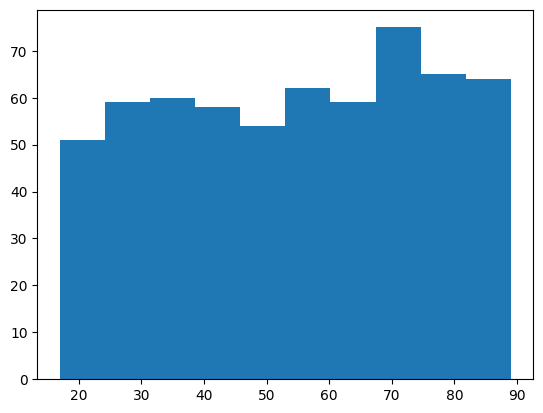

In [227]:
plt.hist(edu_null.age)

(array([228., 237., 252., 255., 238., 297., 184., 199., 258., 245.]),
 array([17. , 24.2, 31.4, 38.6, 45.8, 53. , 60.2, 67.4, 74.6, 81.8, 89. ]),
 <BarContainer object of 10 artists>)

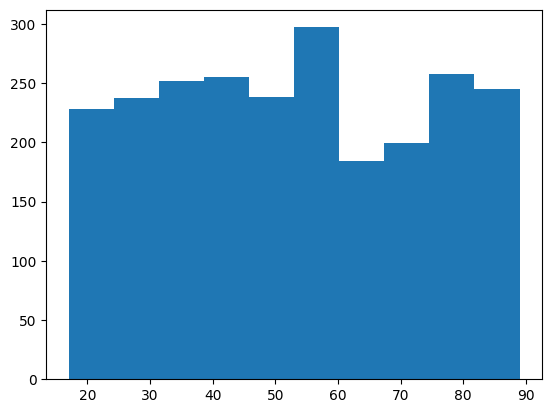

In [228]:
plt.hist(edu_notnull.age)

(array([238.,   0.,   0.,  13.,  65., 187.,  89.,   4.,   8.,   3.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

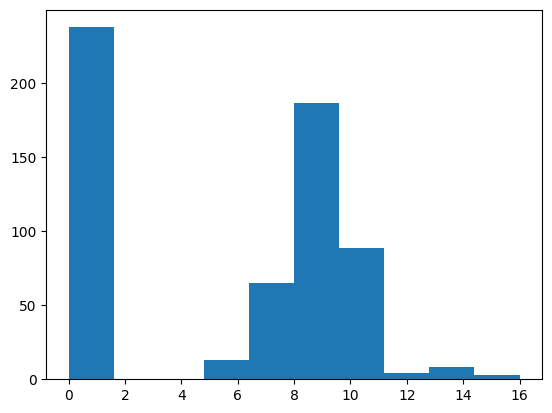

In [229]:
plt.hist(edu_null.mean_working)

(array([794.,   0.,   5., 101., 253., 801., 377.,  22.,  24.,  16.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

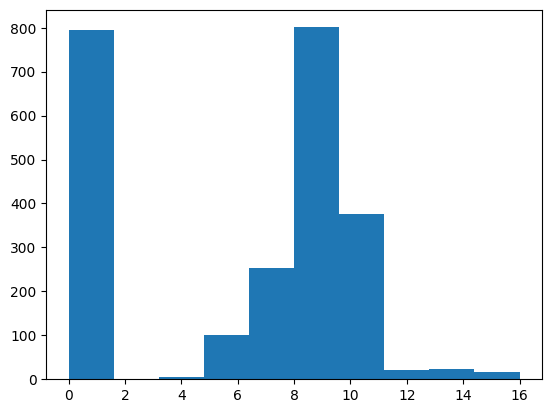

In [230]:
plt.hist(edu_notnull.mean_working)

In [231]:
edu_null["stress_score"].mean()

np.float64(0.5112355848434926)

In [232]:
edu_notnull["stress_score"].mean()

np.float64(0.4747471792728793)

In [233]:
#결측값이 있는 집단과 없는 집단은 유의밀한 차이가 있는지 판단해 봐야 한다.
#나이와 근무 시간을 시각화 화여 비교해본 결과 두 집단사이의 유의미한 차이는 있다고 보기 힘들다
#데이터 결측치 자체를 하나의 데이터로 가정하고 모델을 돌려보자

In [234]:
train['edu_level'] = train['edu_level'].fillna('Unknown')
test['edu_level'] = test['edu_level'].fillna('Unknown')

In [268]:
train.stress_score

0       0.63
1       0.83
2       0.70
3       0.17
4       0.36
        ... 
2995    0.02
2996    0.16
2997    0.16
2998    0.18
2999    0.04
Name: stress_score, Length: 3000, dtype: float64

In [248]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 라벨 인코딩 대상 컬럼
categorical_cols = [
    'gender',
    'activity',
    'smoke_status',
    'medical_history',
    'family_medical_history',
    'sleep_pattern',
    'edu_level'
]

# 각 컬럼별로 LabelEncoder 적용 (train + test 기준 통일)
for col in categorical_cols:
    if col in x_train.columns:  # 혹시 누락된 컬럼 대비 안전 처리
        le = LabelEncoder()
        
        # train과 test 데이터 결합 후 fit → 기준 통일
        combined = pd.concat([x_train[col], test[col]], axis=0).astype(str)
        le.fit(combined)
        
        # 변환 적용
        x_train[col] = le.transform(x_train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))


In [247]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        3000 non-null   object 
 1   gender                    3000 non-null   object 
 2   age                       3000 non-null   int64  
 3   height                    3000 non-null   float64
 4   weight                    3000 non-null   float64
 5   cholesterol               3000 non-null   float64
 6   systolic_blood_pressure   3000 non-null   int64  
 7   diastolic_blood_pressure  3000 non-null   int64  
 8   glucose                   3000 non-null   float64
 9   bone_density              3000 non-null   float64
 10  activity                  3000 non-null   object 
 11  smoke_status              3000 non-null   object 
 12  medical_history           3000 non-null   object 
 13  family_medical_history    3000 non-null   object 
 14  sleep_pa

In [263]:


# depth_list = [-1,3]
# leaves_list = [10,31, 63, 127]
# subsample_list = [0.7, 0.8, 0.9]

# from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# for depth in depth_list:
#     for leaves in leaves_list:
#         for subsample in subsample_list:
#             model = LGBMRegressor(
#                 max_depth=depth,
#                 num_leaves=leaves,
#                 subsample=subsample,
#                 learning_rate=0.05,
#                 n_estimators=1000,
#                 random_state=42
#             )
#             model.fit(
#                 x_tr, y_tr,
#                 eval_set=[(x_val, y_val)],
#                 eval_metric='rmse',
#                 callbacks=[
#                     early_stopping(stopping_rounds=50),
#                     log_evaluation(0)
#                 ]
#             )
#             pred = model.predict(x_val)
#             rmse = mean_squared_error(y_val, pred)
#             if rmse < best_score:
#                 best_score = rmse
#                 best_model = model
#                 best_params = {
#                     'max_depth': depth,
#                     'num_leaves': leaves,
#                     'subsample': subsample
#                 }

# print("📌 Best RMSE:", best_score)
# print("📌 Best Params:", best_params)


In [277]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from lightgbm import LGBMRegressor

# 1. 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 모델 학습
model = LGBMRegressor(random_state=42)
model.fit(x_train, y_train)

# 3. 예측
pred = model.predict(x_test)

# 4. MAE, RMSE 계산
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")

# 📌 Best RMSE: 0.05259653549662293
# model = LGBMRegressor(random_state = 42, num_leaves = 127, subsample = 0.7)
# model.fit(x_train, y_train)

# pred = model.predict(test)

# 📌 Best Params: {'max_depth': -1, 'num_leaves': 127, 'subsample': 0.7}

NameError: name 'X' is not defined

In [270]:
submission = pd.read_csv(r'D:\workspace_1\dacon_venv\test\dataset\sample_submission.csv')

In [271]:
submission['stress_score'] = pred
submission.head()


,ID,stress_score
0,TEST_0000,0.464517
1,TEST_0001,0.641405
2,TEST_0002,0.316468
3,TEST_0003,0.495755
4,TEST_0004,0.633169


In [158]:
submission.to_csv('submit_1.csv', index=False)